In [1]:
!ls

sample_data


In [2]:
# set-up spark (NB if Apache amend versions on download site we will need to amend path in wget command)
## NOTE that this version would make use of Hadoop if installed BUT that HDFS & Hadoop is not installed on our Colab
## (we are only using a single node (probably as a VM) so we will not be able to benefit from parallelism)
!clear
!echo welcome

!rm -f spark-3.3.[01]-bin-hadoop3.tgz* 
!rm -rf spark-3.3.[01]-bin-hadoop3

!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
!tar -xf spark-3.3.2-bin-hadoop3.tgz

!ls -alt
print("standalone Spark is now installed")

welcome
--2023-05-25 13:20:18--  https://downloads.apache.org/spark/spark-3.3.2/spark-3.3.2-bin-hadoop3.tgz
Resolving downloads.apache.org (downloads.apache.org)... 135.181.214.104, 88.99.95.219, 2a01:4f9:3a:2c57::2, ...
Connecting to downloads.apache.org (downloads.apache.org)|135.181.214.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 299360284 (285M) [application/x-gzip]
Saving to: ‘spark-3.3.2-bin-hadoop3.tgz’

spark-3.3.2-bin-had 100%[===================>] 285.49M  20.5MB/s    in 92s     

2023-05-25 13:21:50 (3.12 MB/s) - ‘spark-3.3.2-bin-hadoop3.tgz’ saved [299360284/299360284]

total 292372
drwxr-xr-x  1 root root      4096 May 25 13:21 .
drwxr-xr-x  1 root root      4096 May 25 13:15 ..
drwxr-xr-x  1 root root      4096 May 23 13:31 sample_data
drwxr-xr-x  4 root root      4096 May 23 13:30 .config
-rw-r--r--  1 root root 299360284 Feb 10 21:28 spark-3.3.2-bin-hadoop3.tgz
drwxr-xr-x 13  501 1000      4096 Feb 10 20:40 spark-3.3.2-bin-hadoop3
stand

In [3]:
# init spark (ensure SPARK_HOME set to same version as we download earlier)
!pip3 install findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.2-bin-hadoop3"
import findspark
findspark.init()
from pyspark import SparkConf, SparkContext
# the next line gives us 'local' mode. try 'local[2]' to use 2 cores or 'master:NNNN' to run on Spark standalone cluster at port NNNN
spark_conf = SparkConf().setMaster('local[2]').setAppName('MyApp')
sc = SparkContext(conf=spark_conf)
# see what we have by examining the Spark User Interface
from pyspark.sql import *
from pyspark.sql.functions import *
SparkSession.builder.getOrCreate()
## 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# get file for given year from TfL open data
!wget https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
!unzip cyclehireusagestats-2014.zip

--2023-05-25 13:22:08--  https://cycling.data.tfl.gov.uk/usage-stats/cyclehireusagestats-2014.zip
Resolving cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)... 104.16.101.13, 104.16.100.13
Connecting to cycling.data.tfl.gov.uk (cycling.data.tfl.gov.uk)|104.16.101.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 225215129 (215M) [application/zip]
Saving to: ‘cyclehireusagestats-2014.zip’

cyclehireusagestats 100%[===================>] 214.78M   143MB/s    in 1.5s    

2023-05-25 13:22:09 (143 MB/s) - ‘cyclehireusagestats-2014.zip’ saved [225215129/225215129]

Archive:  cyclehireusagestats-2014.zip
  inflating: 1. Journey Data Extract 05Jan14-02Feb14.csv  
  inflating: 10a. Journey Data Extract 14Sep14-27Sep14.csv  
  inflating: 10b. Journey Data Extract 28Sep14-11Oct14.csv  
  inflating: 11a. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 11b. Journey Data Extract 12Oct14-08Nov14.csv  
  inflating: 12a. Journey Data Extract 09Nov14-06Dec14.csv  
  i

In [5]:
# read in file
!ls
file="./*Journey*csv"
spark = SparkSession.builder.appName("bikes").getOrCreate()
j_df = (spark.read.format("csv")
         .option("header", "true")
         .option("inferSchema", "true")
         .load(file))

# show top 15
j_df.show(15)
     

'10a. Journey Data Extract 14Sep14-27Sep14.csv'
'10b. Journey Data Extract 28Sep14-11Oct14.csv'
'11a. Journey Data Extract 12Oct14-08Nov14.csv'
'11b. Journey Data Extract 12Oct14-08Nov14.csv'
'12a. Journey Data Extract 09Nov14-06Dec14.csv'
'12b. Journey Data Extract 09Nov14-06Dec14.csv'
'13a. Journey Data Extract 07Dec14-21Dec14.csv'
'13b. Journey Data Extract 22Dec14-03Jan15.csv'
'14. Journey Data Extract 08Dec13-04Jan14.csv'
'1. Journey Data Extract 05Jan14-02Feb14.csv'
'2. Journey Data Extract 03Feb14-01Mar14.csv'
'3. Journey Data Extract 02Mar14-31Mar14.csv'
'4. Journey Data Extract 01Apr14-26Apr14.csv'
'5. Journey Data Extract 27Apr14-24May14.csv'
'6. Journey Data Extract 25May14-21Jun14.csv'
'7. Journey Data Extract 22Jun14-19Jul14.csv'
'8a Journey Data Extract 20Jul14-31Jul14.csv'
'8b Journey Data Extract 01Aug14-16Aug14.csv'
'9a Journey Data Extract 17Aug14-31Aug14.csv'
'9b Journey Data Extract 01Sep14-13Sep14.csv'
 cyclehireusagestats-2014.zip
 sample_data
 spark-3.3.2-bin-had

In [6]:
from pyspark.sql.functions import col

j_df = j_df.withColumn("Duration", col("Duration").cast("integer"))


In [7]:
    # group "StartStation Id" and sum their "Duration" (seconds), sort in descending order
    start_df = (j_df.select("StartStation Id", "StartStation Name", "EndStation Id", "EndStation Name","Duration").groupBy("StartStation Id", "StartStation Name")).sum("Duration").orderBy("sum(Duration)", ascending=False)
    # show top 10
    start_df.show(15)
    print('Note "Duration" is in seconds (see above table)')

+---------------+--------------------+-------------+
|StartStation Id|   StartStation Name|sum(Duration)|
+---------------+--------------------+-------------+
|            191|Hyde Park Corner,...|    284098440|
|            307|Black Lion Gate, ...|    206643840|
|            406|Speakers' Corner ...|    166802880|
|            303|Albert Gate, Hyde...|    162463740|
|            407|Speakers' Corner ...|    122890680|
|            213|Wellington Arch, ...|    114115200|
|            248|Triangle Car Park...|     99534600|
|            404|Palace Gate, Kens...|     99427860|
|             14|Belgrove Street ,...|     91753680|
|            541|Green Park Statio...|     82969020|
|            304|Cumberland Gate, ...|     81794280|
|            553|Regent's Row , Ha...|     79968240|
|            153|Bayswater Road, H...|     75771840|
|            154|Waterloo Station ...|     73002840|
|            132|Bethnal Green Roa...|     66036120|
+---------------+--------------------+--------

In [8]:
    # group "EndStation Id" and sum their "Duration", sort in descending order
    end_df = (j_df.select("EndStation Id", "EndStation Name", "EndStation Id", "EndStation Name","Duration").groupBy("EndStation Id", "EndStation Name")).sum("Duration").orderBy("sum(Duration)", ascending=False)
    # show top 15
    end_df.show(15)

+-------------+--------------------+-------------+
|EndStation Id|     EndStation Name|sum(Duration)|
+-------------+--------------------+-------------+
|          191|Hyde Park Corner,...|    241363260|
|          307|Black Lion Gate, ...|    157634700|
|          346|Mechanical Worksh...|    152758740|
|          303|Albert Gate, Hyde...|    148776360|
|          434|Mechanical Worksh...|    125366460|
|          406|Speakers' Corner ...|    124861980|
|          407|Speakers' Corner ...|     98682060|
|           14|Belgrove Street ,...|     95816220|
|          213|Wellington Arch, ...|     93690240|
|          248|Triangle Car Park...|     91223340|
|          404|Palace Gate, Kens...|     88896420|
|          194|Hop Exchange, The...|     79657140|
|          374|Waterloo Station ...|     77717700|
|          341|Craven Street, St...|     71547960|
|          553|Regent's Row , Ha...|     70321140|
+-------------+--------------------+-------------+
only showing top 15 rows



In [9]:
# find rows where Duration is zero
j_df.filter("Duration = 0").count()

32353

sample of  Duration    8897207
dtype: int64


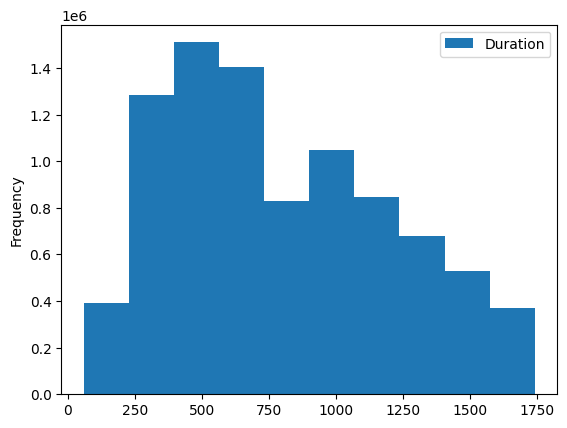

In [10]:
# TO DO: determine how many rows have Duration of over a day  
# try simple plot via pandas (we cover plotting again in demo#3)
import matplotlib.pyplot as plt
import pandas as pd

non_zeros_df = j_df.filter("Duration > 0")
# plot those with duration less than 1800 seconds (0.5 hrs)
pd_df = non_zeros_df.filter("Duration<1800")[["Duration"]].toPandas()
print("sample of ",pd_df.count())

pd_df.plot(kind="hist") # do without and then repeat but set #bins same as Excel (presume 94 bins)
plt.show()

In [11]:
# Calculate the total number of rides
total_rides = j_df.count()

# Calculate the number of rides longer than 3 days
long_rides = j_df.filter(j_df['Duration'] > 259200).count()

# Calculate the percentage
percentage = (long_rides / total_rides) * 100
print("Percentage of rides lasting more than 3 days: ", percentage)

Percentage of rides lasting more than 3 days:  0.024238790495676735


In [12]:
# Checking the DataFrame schema again to confirm the type of 'Start Date'
j_df.printSchema()

root
 |-- Rental Id: string (nullable = true)
 |-- Duration: integer (nullable = true)
 |-- Bike Id: string (nullable = true)
 |-- End Date: string (nullable = true)
 |-- EndStation Id: string (nullable = true)
 |-- EndStation Name: string (nullable = true)
 |-- Start Date: string (nullable = true)
 |-- StartStation Id: string (nullable = true)
 |-- StartStation Name: string (nullable = true)



In [13]:
j_df.head(10)

[Row(Rental Id='34263367', Duration=1080, Bike Id='9076', End Date='24/06/2014 00:57', EndStation Id='695', EndStation Name='Islington Green, Angel', Start Date='24/06/2014 00:39', StartStation Id='311', StartStation Name='Foley Street, Fitzrovia'),
 Row(Rental Id='34603487', Duration=660, Bike Id='6328', End Date='03/07/2014 11:51', EndStation Id='695', EndStation Name='Islington Green, Angel', Start Date='03/07/2014 11:40', StartStation Id='22', StartStation Name='Northington Street , Holborn'),
 Row(Rental Id='34689078', Duration=120, Bike Id='2006', End Date='05/07/2014 15:09', EndStation Id='357', EndStation Name='Howland Street, Fitzrovia', Start Date='05/07/2014 15:07', StartStation Id='311', StartStation Name='Foley Street, Fitzrovia'),
 Row(Rental Id='34724273', Duration=1260, Bike Id='7904', End Date='06/07/2014 16:35', EndStation Id='695', EndStation Name='Islington Green, Angel', Start Date='06/07/2014 16:14', StartStation Id='311', StartStation Name='Foley Street, Fitzrovi

In [20]:
# Check a few rows of the DataFrame to visually inspect the 'Start Date' and 'Month' values
j_df.show(10, truncate=False)

+---------+--------+-------+-------------------+-------------+------------------------------------------+-------------------+---------------+-----------------------------------+-----+----+
|Rental Id|Duration|Bike Id|End Date           |EndStation Id|EndStation Name                           |Start Date         |StartStation Id|StartStation Name                  |month|year|
+---------+--------+-------+-------------------+-------------+------------------------------------------+-------------------+---------------+-----------------------------------+-----+----+
|34263367 |1080    |9076   |2014-06-24 00:57:00|695          |Islington Green, Angel                    |2014-06-24 00:39:00|311            |Foley Street, Fitzrovia            |6    |2014|
|34603487 |660     |6328   |2014-07-03 11:51:00|695          |Islington Green, Angel                    |2014-07-03 11:40:00|22             |Northington Street , Holborn       |7    |2014|
|34689078 |120     |2006   |2014-07-05 15:09:00|357    

In [21]:
from pyspark.sql.functions import to_timestamp

#Assuming the date columns are named 'Start Date' and 'End Date' and they are in the format 'MM/dd/yyyy HH:mm:ss'(Replace with the actual format)

j_df = j_df.withColumn("Start Date", to_timestamp(col("Start Date"), 'dd/MM/yyyy HH:mm'))
j_df = j_df.withColumn("End Date", to_timestamp(col("End Date"), 'dd/MM/yyyy HH:mm'))


In [16]:
# Show the first 15 rows
j_df.show(15)


+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+
| 34263367|    1080|   9076|2014-06-24 00:57:00|          695|Islington Green, ...|2014-06-24 00:39:00|            311|Foley Street, Fit...|
| 34603487|     660|   6328|2014-07-03 11:51:00|          695|Islington Green, ...|2014-07-03 11:40:00|             22|Northington Stree...|
| 34689078|     120|   2006|2014-07-05 15:09:00|          357|Howland Street, F...|2014-07-05 15:07:00|            311|Foley Street, Fit...|
| 34724273|    1260|   7904|2014-07-06 16:35:00|          695|Islington Green, ...|2014-07-06 16:14:00|            311|Foley Street, Fit...|
| 34956750|  

In [17]:
from pyspark.sql.functions import month, year

# Create 'month' and 'year' columns
j_df = j_df.withColumn('month', month(j_df['Start Date']))
j_df = j_df.withColumn('year', year(j_df['Start Date']))

In [18]:
j_df.show()

+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+----+
|Rental Id|Duration|Bike Id|           End Date|EndStation Id|     EndStation Name|         Start Date|StartStation Id|   StartStation Name|month|year|
+---------+--------+-------+-------------------+-------------+--------------------+-------------------+---------------+--------------------+-----+----+
| 34263367|    1080|   9076|2014-06-24 00:57:00|          695|Islington Green, ...|2014-06-24 00:39:00|            311|Foley Street, Fit...|    6|2014|
| 34603487|     660|   6328|2014-07-03 11:51:00|          695|Islington Green, ...|2014-07-03 11:40:00|             22|Northington Stree...|    7|2014|
| 34689078|     120|   2006|2014-07-05 15:09:00|          357|Howland Street, F...|2014-07-05 15:07:00|            311|Foley Street, Fit...|    7|2014|
| 34724273|    1260|   7904|2014-07-06 16:35:00|          695|Islington Green, ...|2014-

In [23]:
from pyspark.sql.functions import mean, col

# Filter for rides in Spring (March, April, May) and calculate average duration
spring_rides = j_df.filter((col('month').between(3,6)) & (col('year') == 2014))
spring_avg_duration = spring_rides.agg(mean('Duration')).collect()[0][0]

# Filter for rides in Autumn (September, October, November) and calculate average duration
autumn_rides = j_df.filter((col('month').between(9,11)) & (col('year') == 2014))
autumn_avg_duration = autumn_rides.agg(mean('Duration')).collect()[0][0]

print(f'Average duration in Spring 2014: {spring_avg_duration} seconds')
print(f'Average duration in Autumn 2014: {autumn_avg_duration} seconds')

# Testing the hypothesis
if autumn_avg_duration > spring_avg_duration:
    print("The hypothesis is true. People ride for longer in Autumn than in Spring.")
else:
    print("The hypothesis is false. People do not ride for longer in Autumn than in Spring.")


Average duration in Spring 2014: 1529.8674672029222 seconds
Average duration in Autumn 2014: 1352.4007267927025 seconds
The hypothesis is false. People do not ride for longer in Autumn than in Spring.
